In [1]:
import wave
import numpy as np
import torch
from matplotlib import pyplot as plt
import glob
import torchaudio
from python_speech_features import mfcc
import os

N_FFT = 512
SAMPLE_RATE = 16000

def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result
def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [2]:
data = glob.glob("data/train/*.wav")

In [3]:
y,sr = torchaudio.load(data[0])
y=y.numpy()
y = torch.FloatTensor(y)
mel = torchaudio.transforms.MelSpectrogram()(y)
mel = torchaudio.transforms.AmplitudeToDB()(mel)
print(type(mel))
mel = torch.FloatTensor(mel)
print(type(mel))
print(mel.shape)

In [6]:
y,sr = torchaudio.load(data[0])
y = y.numpy()
mel = torchaudio.transforms.MelSpectrogram()(y)

RuntimeError: forward() Expected a value of type 'Tensor' for argument 'waveform' but instead found type 'ndarray'.
Inferred 'waveform' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 1
Value: array([[0.00024414, 0.00027466, 0.00024414, ..., 0.00036621, 0.00036621,
        0.00036621]], dtype=float32)
Declaration: forward(ClassType<MelSpectrogram> self, Tensor waveform) -> (Tensor)

In [3]:
datas = []
for i in data:
    rate, width, sig = readwav(i)
    sig = sig.ravel()
    datas.append(sig)

/home/jhm9507/anaconda3/envs/jhm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


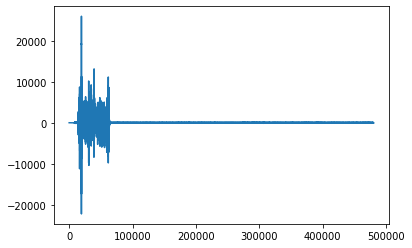

In [4]:
plt.plot(datas[76])

In [5]:
test = torch.stft(torch.FloatTensor(datas[76]),
                        N_FFT,
                        hop_length=int(0.01*SAMPLE_RATE),
                        win_length=int(0.030*SAMPLE_RATE),
                        window=torch.hamming_window(int(0.030*SAMPLE_RATE)),
                        center=False,
                        normalized=False,
                        onesided=True)

In [6]:
test.shape

torch.Size([257, 2997, 2])

In [7]:
def cut_sig(sig):
    start = 0
    end = len(sig)-1
    for hz in sig:
        if hz < 200:
            start += 1
        else:
            break
    for hz in sig[::-1]:
        if hz < 200:
            end -= 1
        else:
            break
    return sig[start:end]

In [24]:
def get_spectrogram_feature(filepath):
#     (rate, width, sig) = readwav(filepath)
#     sig = sig.ravel()
    sig = filepath
#     sig = cut_sig(sig)
    plt.plot(sig)
    print(np.max(sig), np.min(sig), np.mean(sig))
    stft = torch.stft(torch.FloatTensor(sig),
                        N_FFT,
                        hop_length=int(0.01*SAMPLE_RATE),
                        win_length=int(0.030*SAMPLE_RATE),
                        window=torch.hamming_window(int(0.030*SAMPLE_RATE)),
                        center=False,
                        normalized=False,
                        onesided=True)
    stft = (stft[:,:,0].pow(2) + stft[:,:,1].pow(2)).pow(0.5);
    amag = stft.numpy();
    print(amag.shape)
    print(np.max(amag),np.min(amag),np.mean(amag))
    feat = torch.FloatTensor(amag)
    feat = torch.FloatTensor(feat).transpose(0, 1)

    return feat

In [25]:
test = get_spectrogram_feature(datas[76])

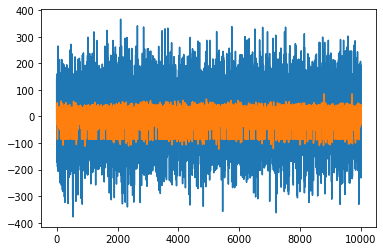

In [10]:
noise = np.random.normal(scale=100.0,size=len(datas[76]))
noised = datas[76]+noise
plt.plot(noised[200000:210000])
plt.plot(datas[76][200000:210000])

25973 -22224 0.92675625
(257, 2997)
976323.2 0.0 925.7873
torch.Size([2997, 257])


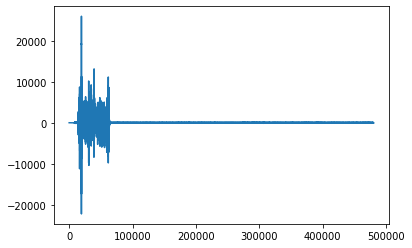

In [11]:
test = get_spectrogram_feature(datas[76])
print(test.shape)

In [12]:
test.shape

torch.Size([2997, 257])

(array([7.59975e+05, 3.96500e+03, 1.89400e+03, 1.11300e+03, 7.05000e+02,
        5.03000e+02, 3.44000e+02, 2.96000e+02, 2.26000e+02, 1.95000e+02,
        1.49000e+02, 1.35000e+02, 1.03000e+02, 8.10000e+01, 1.01000e+02,
        6.80000e+01, 6.40000e+01, 5.00000e+01, 3.70000e+01, 3.60000e+01,
        2.70000e+01, 1.70000e+01, 1.40000e+01, 1.70000e+01, 2.00000e+01,
        9.00000e+00, 1.10000e+01, 1.00000e+01, 1.20000e+01, 5.00000e+00,
        4.00000e+00, 8.00000e+00, 3.00000e+00, 4.00000e+00, 3.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

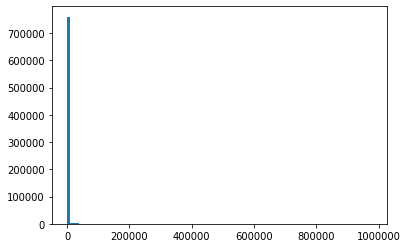

In [13]:
x = []
for i in test:
    for j in i:
        x.append(j)
plt.hist(x,bins=100)

In [14]:
np.max(x)

976323.2

In [15]:
len(x)

770229

In [16]:
x = np.array(x)
len(x[x>10000])

10102

25973 -22224 0.92675625
(257, 2997)
976323.2 0.0 925.7873


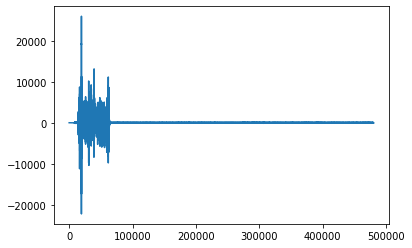

In [17]:
test = get_spectrogram_feature(datas[76])

In [18]:
test.shape

torch.Size([2997, 257])

In [19]:
np.max(np.array(test))

976323.2

In [3]:
x = torch.randn(size=(4,820))
y = torch.randint(high=819,size=(4,))
criterion = torch.nn.CrossEntropyLoss()
loss=criterion(x,y)